## Step 1: Importing Libraries and Loading the Data

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
data_path = 'Swarm_Behaviour.csv'
df = pd.read_csv(data_path)

# Preview the first few rows of the dataset
df.head()

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Swarm_Behaviour
0,562.05,-0.62,-10.70,-4.33,0.00,0.00,0.0,0.0,0.00,0.00,...,-15.15,0.00,0.00,0.00,0.00,0.00,0.0,28,0,0.0
1,175.66,-57.09,2.31,-2.67,0.00,0.00,0.0,0.0,0.00,0.00,...,-3.48,0.00,0.00,0.00,0.00,0.00,0.0,4,0,0.0
2,200.16,-320.07,4.01,-6.37,0.00,0.00,0.0,0.0,0.18,-0.26,...,-9.38,0.00,0.00,0.00,0.00,-0.11,-0.3,15,1,0.0
3,316.99,-906.84,0.85,9.17,-0.17,1.03,0.0,0.0,0.00,0.00,...,10.39,-0.26,1.01,0.00,0.00,0.00,0.0,16,0,0.0
4,1277.68,908.54,-2.02,8.23,-1.00,1.00,0.0,0.0,0.00,0.00,...,13.91,-1.00,0.00,3.21,15.67,0.00,0.0,12,0,0.0


In [3]:
# Show some basic information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23309 entries, 0 to 23308
Columns: 2401 entries, x1 to Swarm_Behaviour
dtypes: float64(2001), int64(400)
memory usage: 427.0 MB


## Step 2: Data Preparation and Balancing

In [4]:
# We noticed that the data type of Swarm_Behaviour was interpreted as float, it is supposed to be integer
# Convert the target column 'Swarm_Behaviour' to integer type
df['Swarm_Behaviour'] = df['Swarm_Behaviour'].astype(int)

# Check for missing values in the dataset
total_missing = df.isnull().sum().sum()
print("Total missing values in the dataset:", total_missing)

Total missing values in the dataset: 0


Training set shape: (16316, 2400)
Validation set shape: (3496, 2400)
Test set shape: (3497, 2400)


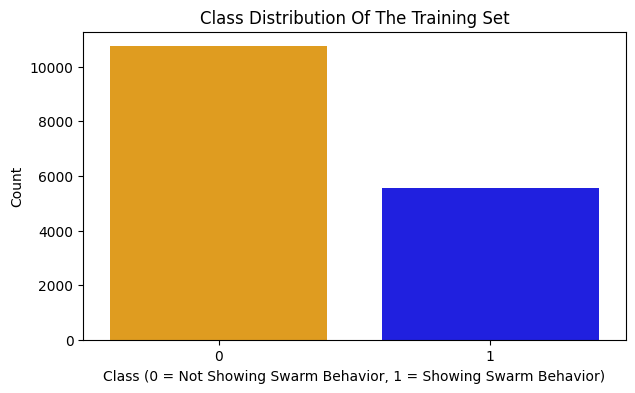

Class distribution of the training set:
Swarm_Behaviour
0    10748
1     5568
Name: count, dtype: int64


In [5]:
# Separate features (X) and target (y)
X = df.iloc[:, :-1]  # All columns except the last one (features)
y = df.iloc[:, -1]   # The last column, swarm_behaviour (target)

# Split the data into 70% train and 30% (temp set for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the temp set into 50% validation and 50% test (this results in 15% validation and 15% test overall)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the shapes of each set
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Visualize the class distribution of the training set
plt.figure(figsize=(7, 4))
sns.countplot(x=y_train, hue=y_train, palette={0: 'orange', 1: 'blue'}, dodge=False, legend=False)
plt.title('Class Distribution Of The Training Set')
plt.xlabel('Class (0 = Not Showing Swarm Behavior, 1 = Showing Swarm Behavior)')
plt.ylabel('Count')
plt.show()


# Print the class distribution
print("Class distribution of the training set:")
print(y_train.value_counts())

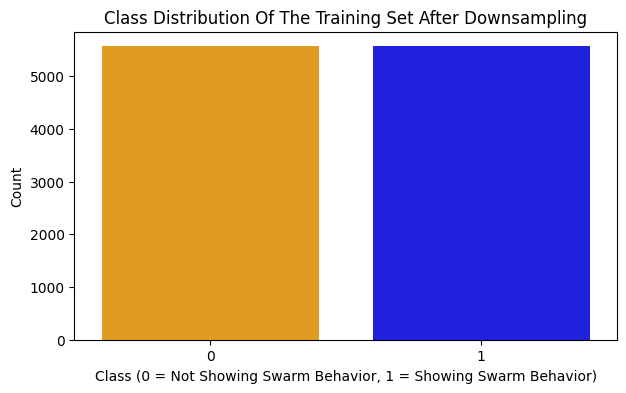

Class distribution of the training set after downsampling:
Swarm_Behaviour
0    5568
1    5568
Name: count, dtype: int64


In [6]:
# Since there's an imbalance between two classes in the training set, we use downsampling
# Combine X_train and y_train into a single DataFrame to make downsampling easier
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes in the training set
majority_class = train_data[train_data['Swarm_Behaviour'] == 0]  # "Not showing swarm behavior"
minority_class = train_data[train_data['Swarm_Behaviour'] == 1]  # "Showing swarm behavior"

# Downsample the majority class to match the size of the minority class
# Random_state=42 for reproducibility
majority_class_downsampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class to create a balanced training dataset
train_data_balanced = pd.concat([majority_class_downsampled, minority_class])

# Separate the features (X_train_balanced) and target (y_train_balanced) again for the balanced training set
X_train_balanced = train_data_balanced.iloc[:, :-1]  # All columns except the last one (features)
y_train_balanced = train_data_balanced['Swarm_Behaviour']   # The last column (target)

# Visualize the class distribution after downsampling
plt.figure(figsize=(7, 4))
sns.countplot(x=y_train_balanced, hue=y_train_balanced, palette={0: 'orange', 1: 'blue'}, dodge=False, legend=False)
plt.title('Class Distribution Of The Training Set After Downsampling')
plt.xlabel('Class (0 = Not Showing Swarm Behavior, 1 = Showing Swarm Behavior)')
plt.ylabel('Count')
plt.show()

# Show the class distribution after downsampling
print("Class distribution of the training set after downsampling:")
print(y_train_balanced.value_counts())

In [7]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the features for both training and testing sets
X_train_scaled = scaler.fit_transform(X_train_balanced)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)    # Only transform the test data (no fitting again)
X_val_scaled = scaler.transform(X_val)      # Transform the validation data

# Show the shape of the training and test sets after balancing
print("Balanced training set shape (X_train_balanced): ", X_train_balanced.shape)
print("Test set shape (X_test): ", X_test.shape)

Balanced training set shape (X_train_balanced):  (11136, 2400)
Test set shape (X_test):  (3497, 2400)


## Step 3: Logistic Regression Training and Evaluation

__Note:__ Before you run the next cell, the training process might take up to an hour due to the size of the data. 

Our training set, while substantial, includes 11,136 samples and 2,400 features, making traditional k-fold cross-validation with methods like GridSearchCV potentially very computationally expensive and time-consuming. Therefore, We chose manual hyperparameter tuning because it offers a balance between computational efficiency and effective hyperparameter optimization. Manual tuning allowed us to explore key hyperparameters—such as the regularization strength (C) and penalty type (l1 or l2)—in a more targeted manner, ensuring we were able to make effective adjustments without overwhelming computational demands.

Additionally, by using our dedicated validation set for tuning, we could ensure that our model generalized well without the need for extensive re-training across multiple cross-validation folds.

In [ ]:
# Define the hyperparameter values to explore
C_values = [0.01, 0.1, 1, 10, 100]
penalties = ['l1', 'l2']
solver = 'saga'

# Store the results for each combination
results = []

# Loop through each combination of C and penalty
for C in C_values:
    for penalty in penalties:
        try:
            # Initialize the Logistic Regression model with given C and penalty
            logreg = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=5000, random_state=42)

            # Train the model using the training data
            logreg.fit(X_train_scaled, y_train_balanced)

            # Predict on the training set
            y_train_pred = logreg.predict(X_train_scaled)
            train_accuracy = accuracy_score(y_train_balanced, y_train_pred)

            # Predict on the validation set
            y_val_pred = logreg.predict(X_val_scaled)
            val_accuracy = accuracy_score(y_val, y_val_pred)

            # Save the results
            results.append({'C': C, 'penalty': penalty, 'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy})

            print(f"Trained with C={C}, penalty={penalty} -> Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        except Exception as e:
            # Some combinations might not work (e.g., 'l1' with certain solvers) so we will handle these exceptions
            print(f"Failed for C={C}, penalty={penalty}: {e}")

# Extract the results for plotting
C_values_plotted = [result['C'] for result in results]
train_accuracies = [result['train_accuracy'] for result in results]
val_accuracies = [result['val_accuracy'] for result in results]

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(C_values_plotted, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(C_values_plotted, val_accuracies, marker='o', label='Validation Accuracy')
plt.xscale('log')  # Log scale for C values to better visualize the impact
plt.xlabel('C (Regularization Strength - Inverse)')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy for Different Values of C')
plt.legend()
plt.grid(True)
plt.show()

After looping through the combination of C and penalty, we found that the model produces better results with lower C and regulation L1. The best accuracy score (0.9062) was achived with C = 0.01 and penalty L1. For the model trained with these parameters, the training accuracy is 0.9196 and validation accuracy is 0.9062, these are both high and the gap between them is relatively small, suggesting that the model is  well-generalized.

We will proceed on testing the model on the test set.

In [ ]:
# Retrain the model using the best hyperparameters on the training data
best_C = 0.01
best_penalty = 'l1'
solver = 'saga'

# Initialize the Logistic Regression model with the best found parameters
best_logreg = LogisticRegression(C=best_C, penalty=best_penalty, solver=solver, max_iter=5000, random_state=42)

# Fit the model to the training set
best_logreg.fit(X_train_scaled, y_train_balanced)

LogisticRegression(C=0.01, max_iter=5000, penalty='l1', random_state=42,
                   solver='saga')

Note: A quick re-evaluation on the validation set to get some figures for the report. For the graders and/or anyone who wants to run our project, you can skip this cell.

In [ ]:
y_val_pred = best_logreg.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Set Accuracy: {val_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
    
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Swarming', 'Swarming'], yticklabels=['Not Swarming', 'Swarming'])
plt.title('Confusion Matrix')
plt.ylabel('Real Label')
plt.xlabel('Predicted Label')
plt.show()

Make the prediction, calculate and illustrate the evaluation on the test set.

In [1]:
# Predict on the test set
y_test_pred = best_logreg.predict(X_test_scaled)

# Calculate accuracy score on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Additional evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Calculate and visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Swarming', 'Swarming'], yticklabels=['Not Swarming', 'Swarming'])
plt.title('Confusion Matrix')
plt.ylabel('Real Label')
plt.xlabel('Predicted Label')
plt.show()

NameError: name 'best_logreg' is not defined

## Step 4: Random Forest Training and Evaluation

First, we need to import the RandomForestClassifer

In [8]:
from sklearn.ensemble import RandomForestClassifier

Since Random Forest does not require feature scaling, we will use the training set X_train_balanced. 

We initialize the Random Forest model with 100 trees.

In [9]:
# Initialize the Random Forest Model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model on the balanced training set
rf_classifier.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

Evaluation on the validation set

Validation Accuracy: 0.8801487414187643
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      2303
           1       0.79      0.89      0.84      1193

    accuracy                           0.88      3496
   macro avg       0.86      0.88      0.87      3496
weighted avg       0.89      0.88      0.88      3496

Validation Confusion Matrix:


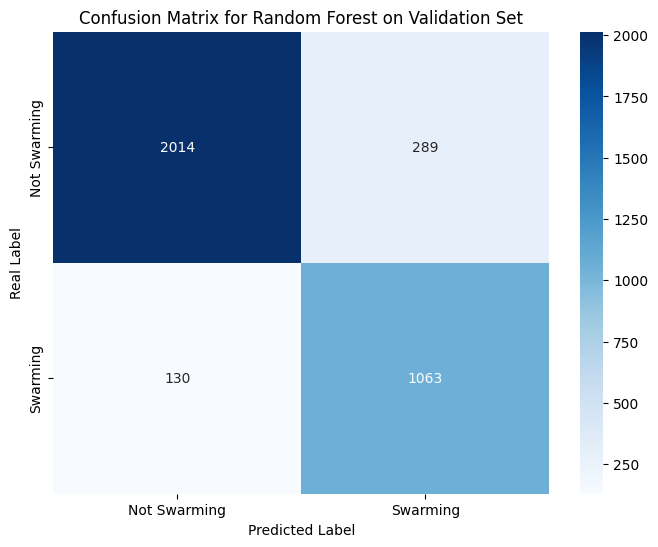

In [10]:
# Evaluate the model on the validation set
y_val_pred = rf_classifier.predict(X_val)

# Calculate and print validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Classification Report on validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix on validation set
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Validation Confusion Matrix:")

# Visualize Confusion Matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Swarming', 'Swarming'], yticklabels=['Not Swarming', 'Swarming'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Real Label')
plt.title('Confusion Matrix for Random Forest on Validation Set')
plt.show()

Now, we will evaluate the model on the training set, then compare the model's performance on both training and validation set to see how well-generalized it is.

Training Accuracy: 0.9731501436781609

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5568
           1       0.97      0.98      0.97      5568

    accuracy                           0.97     11136
   macro avg       0.97      0.97      0.97     11136
weighted avg       0.97      0.97      0.97     11136



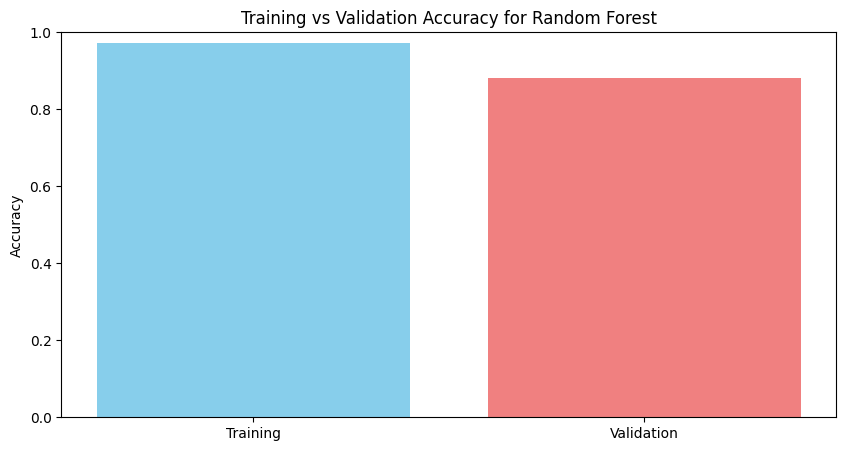

In [11]:
# Evaluate on the Training Set
y_train_pred = rf_classifier.predict(X_train_balanced)

# Calculate and print traing accuracy
train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Classification Report on training set
print("\nTraining Classification Report:")
print(classification_report(y_train_balanced, y_train_pred))

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.bar(['Training', 'Validation'], [train_accuracy, val_accuracy], color=['skyblue', 'lightcoral'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy for Random Forest')
plt.show()

From the result, we can see that the training accuracy (97.3%) is substantially higher than the validation accuracy (88%), suggesting overfitting. The precision score for label 1 on the validation set is also low, at 0.79.

The model performs well on the training set but has a noticeable drop in metrics like precision and F1-score for the validation set, indicating a lack of generalization. Therefore, we will implement hyperparmeter tuning to improve the generalization on unseen data.

To tune this Random Forest model, we will use RandomizedSearchCV. Unlike the Logistic Regression model, where hyperparameter tuning extremely computaionally expensive for large dataset, Random Forest can train multiple trees relatively faster than Logistic Regression. This is because individual trees often use a subset of features, which reduces the dimensionality each tree sees during training, and Random Forest algorithms are highly parallelizable, making efficient use of multiple cores, which speeds up the fitting process significantly.

In [21]:
# Hyperparameter Tuning using RandomizedSearchCV (with corrected max_features)
from sklearn.model_selection import RandomizedSearchCV

# Define the corrected parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],          # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': [None, 'sqrt', 'log2']     # Corrected to use valid options for max_features
}

# Initialize RandomizedSearchCV with the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)  # Base classifier
rf_random_search = RandomizedSearchCV(estimator=rf_classifier,
                                      param_distributions=param_grid,
                                      n_iter=50,        # Number of parameter settings sampled
                                      cv=3,             # 3-fold cross validation
                                      verbose=2,        # Print updates during the process
                                      random_state=42,  # For reproducibility
                                      n_jobs=-1)        # Use all available CPU cores

# Fit RandomizedSearchCV to the balanced training data
rf_random_search.fit(X_train_balanced, y_train_balanced)

# Display the best parameters found by RandomizedSearchCV
best_params = rf_random_search.best_params_
print("Best Parameters from RandomizedSearchCV:")
print(best_params)

# Extract the best estimator
best_rf_classifier = rf_random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters from RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


We received the best parameters from RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}.

Now we will evaluate the tuned model on the validation set.

Validation Accuracy after Tuning: 0.8958810068649885

Validation Classification Report after Tuning:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2303
           1       0.78      0.97      0.86      1193

    accuracy                           0.90      3496
   macro avg       0.88      0.91      0.89      3496
weighted avg       0.91      0.90      0.90      3496


Validation Confusion Matrix after Tuning:
[[1976  327]
 [  37 1156]]


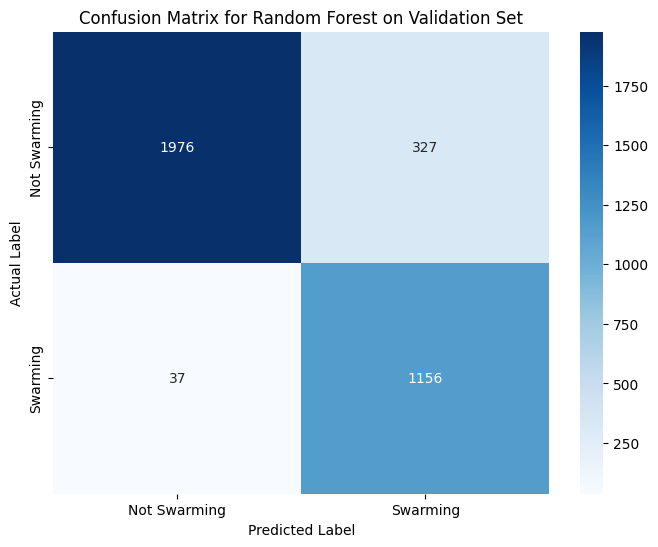

In [24]:
# Using the best estimator from RandomizedSearchCV for evaluation
best_rf_classifier = rf_random_search.best_estimator_

# Evaluate on the Validation Set
y_val_pred = best_rf_classifier.predict(X_val)

# Validation Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy after Tuning:", val_accuracy)

# Classification Report on Validation Set
print("\nValidation Classification Report after Tuning:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix for Validation Set
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
print("\nValidation Confusion Matrix after Tuning:")
print(val_conf_matrix)

# Visualize Confusion Matrix for the Validation Set
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Swarming', 'Swarming'], 
            yticklabels=['Not Swarming', 'Swarming'])
plt.title('Confusion Matrix for Random Forest on Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

Summary of the performance of Random Forest model after tuning:

- Validation Accuracy improved from 88.0% to 89.6% after tuning, indicating overall improved performance.

- Recall for Class 1 ("Swarming") increased significantly, showing that the tuned model is better at detecting true positives.

- However, precision for Class 1 decreased slightly, suggesting the model is now making more false positive predictions for "Swarming."

- The trade-off between recall and precision is evident: improvements in recall came at the cost of a small reduction in precision.

Now we can evaluate the model on the test set.

Test Accuracy after Tuning: 0.8973405776379754

Test Classification Report after Tuning:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2304
           1       0.78      0.97      0.87      1193

    accuracy                           0.90      3497
   macro avg       0.88      0.92      0.89      3497
weighted avg       0.91      0.90      0.90      3497


Test Confusion Matrix after Tuning:
[[1976  328]
 [  31 1162]]


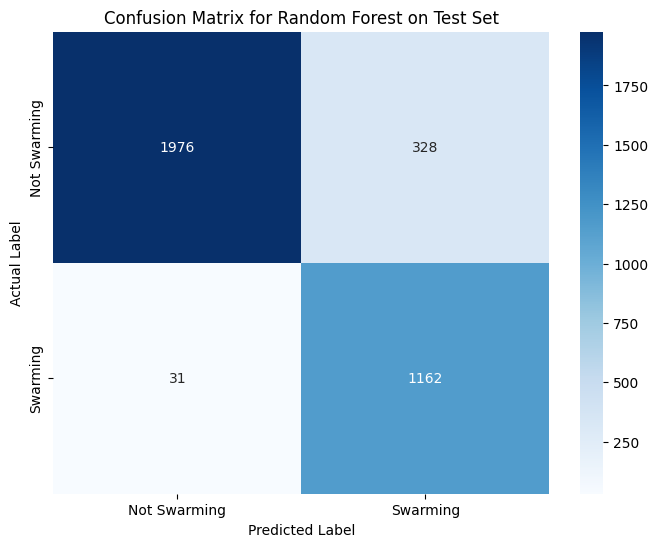

In [26]:
# Evaluation on the test set
best_rf_classifier = rf_random_search.best_estimator_

# Make predictions on the test set
y_test_pred = best_rf_classifier.predict(X_test)

# Calculate the Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy after Tuning:", test_accuracy)

# Generate a Classification Report for the Test Set
print("\nTest Classification Report after Tuning:")
print(classification_report(y_test, y_test_pred))

# Compute the Confusion Matrix for the Test Set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nTest Confusion Matrix after Tuning:")
print(test_conf_matrix)

# Visualize the Confusion Matrix for the Test Set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Swarming', 'Swarming'], 
            yticklabels=['Not Swarming', 'Swarming'])
plt.title('Confusion Matrix for Random Forest on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


The hyperparameter tuning process led to a notable improvement in recall for class 1 ("Swarming") and an overall increase in the model's F1-score, demonstrating that the model is better at detecting true positives for the minority class. However, this improvement in recall came at a slight cost to precision, increasing the number of false positives for class 1.

To further enhance the performance of our Random Forest model, particularly aiming to improve precision for class 1 ("Swarming") while maintaining or improving overall recall, we propose the following actions:

1. Adjust the Decision Threshold for Class 1: Currently, the default decision threshold of 0.5 is leading to high recall but reduced precision for class 1, resulting in more false positives. To mitigate this, we recommend increasing the decision threshold to 0.6 or 0.65, which would make the model more conservative when predicting "Swarming" and help reduce false positives. This adjustment aims to increase precision without significantly sacrificing recall.

2. Class Weight Adjustment: Our model could benefit from adjusting the class weights to balance the predictions between class 0 ("Not Swarming") and class 1. By setting class_weight='balanced', or manually fine-tuning the weights, we can emphasize minimizing false positives for class 1. This will help the model make fewer incorrect predictions for "Swarming," thereby improving precision.

3. Re-tune Hyperparameters with Precision as the Objective: We originally optimized our hyperparameters based on accuracy. While this yielded good results overall, optimizing for precision as the primary scoring metric could further help reduce false positives, making the model more selective. We recommend using RandomizedSearchCV again, but this time with precision-focused tuning to better target our specific objective.